In [3]:
%pylab inline


pylab.rcParams['figure.figsize'] = (16.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


In [4]:
from collections import Counter
import heapq
import sympy,re
from sympy.abc import x
import os
import glob
from pprint import pprint
from collections import OrderedDict
import seaborn as sns
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

In [5]:
def import_cfs(directory, filename):
    os.chdir(directory)
    d = [open(f,'r') for f in glob.glob(filename+'*')]
    cf ={}
    for f in d:
        key = f.readline()
        cf[key] = []
        for i in f.readlines():
            a = int(i.split(',')[0])
            cf[key].append(int(a))
    return cf

def get_maxes(cf):
    maxes={p:[] for p in cf}
    prevMax = {p:0 for p in cf}
    for p in cf:
        for c in cf[p]:
            prevMax[p] = max(c, prevMax[p])
            maxes[p].append(prevMax[p])
    return maxes

def get_means(cf):
    means = {c:numpy.cumsum(cf[c]) for c in cf}
    for c in cf:
        for i in range(1,len(cf[c])+1):
            means[c][i-1] = means[c][i-1]/i
    return means

def get_runningmeans(cf, var):
    return {c:np.convolve(cf[c], np.ones((var, ))/var, mode='valid') for c in cf}

def get_counts(cf):
    return {p : Counter(cf[p]) for p in cf}

def diamond_vaaler(cfs, limit):
    output = {}
    for p in cfs:
        c = cfs[p]
        m = 0
        s = 0
        for i in range(1,limit-1):
            value = c[i]
            m = max(m, value)
            s = s + value
        store = (s-m)/(limit * log(limit))
        output[p] = store
    return output

def khintchine(cfs, limit):
    output = {}
    for p in cfs:
        c = cfs[p]
        m = 1
        values = []
        for i in range(1,limit-1):
            value = c[i]
            m = m*value
        exponent = m.bit_length()/float(limit)
        store=pow(2,exponent)
        output[p] = store
    return output

In [6]:

def maxes_list(cf):
    t=[[0 for i in range(2*len(cf))] for i in range(10)]
    m=0
    for p in cf:
        a=numpy.array(cf[p])
        ind = np.argpartition(a, -10)[-10:]
        ind=sort(ind)
        n=0
        for i in ind:
            t[n][2*m]=i
            t[n][2*m+1]=a[i]
            n+=1
        m+=1
    return t

def sympy_poly(p):
    p =re.sub("[^0-9\-]", ",",p).split(",")
    coeffs = [int(c) for c in p if c!='']
    counter = 0
    y = sympy.poly(0,x)
    for c in coeffs:
        y += sympy.poly(c*x**counter, x)
        counter +=1
    return y

def latex_poly(p):
    return sympy.latex(p.as_expr(), mode='inline')

def disc_poly(p):
    return sympy.discriminant(p)

def plot_stuff(data):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    pyplot.rc('text', usetex=True)
    pyplot.rc('font', family='serif')
    plots= []
    for p in data:
        ax.plot(data[p], label=latex_poly(sympy_poly(p)))
    pyplot.legend(loc='upper right');
    ax.figure.show()

def print_polys(cf):
    for c in cf:
        p = sympy_poly(c)
        print(latex_poly(p)+' & '+str(sympy.discriminant(p))  + ' & ' + str(len(cf[c]))+' \\\\')
        
def most_common(cf,ordering):
    counts= get_counts(cf)
    counts=OrderedDict(sorted(counts.items(), key=ordering))
    n=0
    t= [[0 for i in range(len(cf))] for i in range(10)]
    for p in cf:
        for i in counts[p].most_common(10):
            t[i[0]-1][n]=i[1]*1.0/len(cf[p])
        n+=1
    return t

def export_latex_table(t,f,s,h=""):
    numpy.savetxt(s+".csv", t, delimiter=' & ', fmt=f, header = h, newline=' \\\\\n')
    
def check(cf):
    for c in cf:
        n = 0
        for k in cf[c]:
            n+=1
            if (k<=0):
                print("oh dear")
                print(c)
                print(n)
                cf.pop(c)
                break
                
def print_polys_data(data, titles):
    s= "Poly" + ' & '
    s = s+''.join(t + ' & ' for t in titles)
    s = s[:-2] +' \\\\'
    print(s)
    for c in data:
        p = sympy_poly(c)
        s=latex_poly(p)+' & '
        for d in data[c]:
            s+= str(d) + ' & '
        print(s[:-2]  +' \\\\')

In [7]:
def plot_data(x,y, expected,title):
    dvnumbers = [n-expected for n in y.values()]
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, dvnumbers, label=title)
    pyplot.legend(loc='upper right');
    ax.figure.show()

In [43]:

def plot_table(data, x_axis, label):
    plt = pyplot
    
    fig = pyplot.figure()
    host = host_subplot(111, axes_class=AA.Axes)
    pyplot.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 60
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))

    par2.axis["right"].toggle(all=True)

    
    m = [data[k][1] for k in data.keys()]
    
    host.set_xlim(0, x_axis[-1])
    host.set_ylim(0, 0.75*max(m))
    
    host.set_xlabel("Polynomial" + label)
    host.set_ylabel("Max")
    par1.set_ylabel("Diamond Vaaler")
    par2.set_ylabel("Khintchine")

    kh=[data[k][3] for k in data.keys()]
    dv = [data[k][2] for k in data.keys()]

    x = x_axis
    p1, = host.plot(x, m, label="Max")
    p2, = par1.plot(x, dv, label="Diamond Vaaler")
    p3, = par2.plot(x, kh, label="Khintchine")

    par1.set_ylim(min(dv)*1.25, 1.25*max(dv))
    par2.set_ylim(min(kh)*1.25, 1.25*max(kh))

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())

    plt.draw()
    plt.show()
    
def xaxis(data,heightordegree):
    keys = data.keys()
    x=[]
    for p in keys:
        p =re.sub("[^0-9\-]", ",",p).split(",")
        coeffs = [int(c) for c in p if c!='']
        if (heightordegree == "height"):
            x.append(abs(coeffs[0]))
        else:
            x.append(len(coeffs))
    return x



In [28]:
def doeverything(name, folder, filename, ordering):
    notorderedcf = import_cfs(folder,filename)
    cf = OrderedDict(sorted(notorderedcf.items(), key=ordering))
    check(cf)
    print_polys(cf)
    
    titles = ["Discriminant", "Max",  "DV", "Khintchine"]
    data = OrderedDict((c,[sympy.discriminant(sympy_poly(c))]) for c in cf.keys() )
    amount = min([len(i) for i in cf.values()])
    
    maxes = get_maxes(cf)
    for k in maxes:
        data[k].append(maxes[k][amount-1])
        
    plot_stuff(OrderedDict(sorted(maxes.items(), key=ordering)))
    savefig(name + '_max.pdf')

    plot_stuff(OrderedDict(sorted(get_means(cf).items(), key=ordering)))
    savefig(name + '_means.pdf')

    dexpected = 1/ (log(2))
    dv=diamond_vaaler(cf, amount)
    for k in dv:
        data[k].append(abs(dv[k]-dexpected))

    
    kexpected = 2.685452001065306445309714835481
    khint=khintchine(cf, amount)
    for k in khint:
        data[k].append(abs(khint[k]-kexpected))
        

        
    print_polys_data(data, titles)
    
    plot_table(data,xaxis(data, name),name)
    
    header = ''.join(latex_poly(sympy_poly(p)) + ' & ' for p in cf.keys()) + ' \\\\'
    export_latex_table(most_common(cf,ordering),'%0.5f',name+"_most_common", h = header)

    rt=maxes_list(cf)

    export_latex_table(rt,'%0i',name + "_maxes", h = header)
    return cf, data

In [29]:
def degree_compare(f):
    return sympy.polys.polytools.degree(sympy_poly(f[0]), x)

def disc_compare(f):
    return abs(sympy.discriminant(sympy_poly(f[0])))

$x^{3} - 3$ & -243 & 460165 \\
$x^{3} - 5$ & -675 & 639024 \\
$x^{3} - 6$ & -972 & 673595 \\
$x^{3} - 7$ & -1323 & 540282 \\
$x^{3} - 9$ & -2187 & 589638 \\
$x^{3} - 10$ & -2700 & 627750 \\
$x^{3} - 11$ & -3267 & 559136 \\
$x^{3} - 12$ & -3888 & 844566 \\
$x^{3} - 13$ & -4563 & 643105 \\
$x^{3} - 14$ & -5292 & 783619 \\
$x^{3} - 15$ & -6075 & 433664 \\
$x^{3} - 16$ & -6912 & 540202 \\
$x^{3} - 17$ & -7803 & 673081 \\
$x^{3} - 18$ & -8748 & 844590 \\
$x^{3} - 19$ & -9747 & 445063 \\
$x^{3} - 20$ & -10800 & 764984 \\
$x^{3} - 21$ & -11907 & 817747 \\
$x^{3} - 22$ & -13068 & 456515 \\
$x^{3} - 23$ & -14283 & 635566 \\
$x^{3} - 24$ & -15552 & 730533 \\
$x^{3} - 25$ & -16875 & 608604 \\
$x^{3} - 26$ & -18252 & 490827 \\
$x^{3} - 28$ & -21168 & 730725 \\
$x^{3} - 29$ & -22707 & 642605 \\
$x^{3} - 30$ & -24300 & 471567 \\
$x^{3} - 31$ & -25947 & 445071 \\
$x^{3} - 32$ & -27648 & 787467 \\
$x^{3} - 33$ & -29403 & 597105 \\
$x^{3} - 34$ & -31212 & 551607 \\
$x^{3} - 35$ & -33075 & 623912 \\
$x^

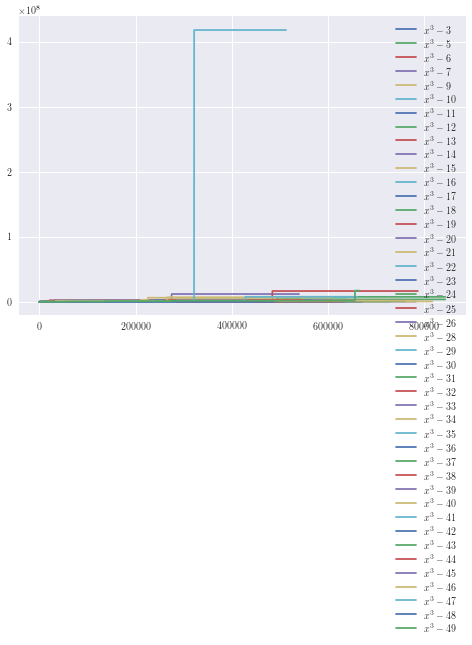

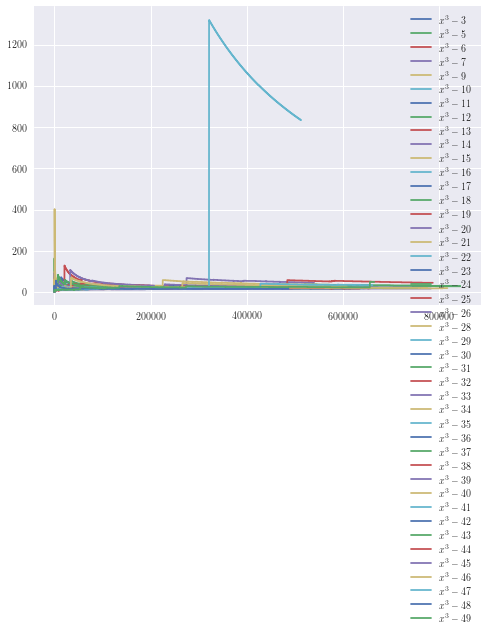

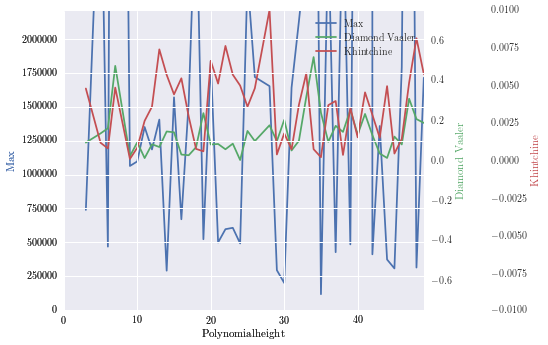

In [30]:
heightcf, heightdata =doeverything("height", '/usr/userfs/s/sjb577/shared/cf/polysheight/','increasing_height.job.o1018760', disc_compare)

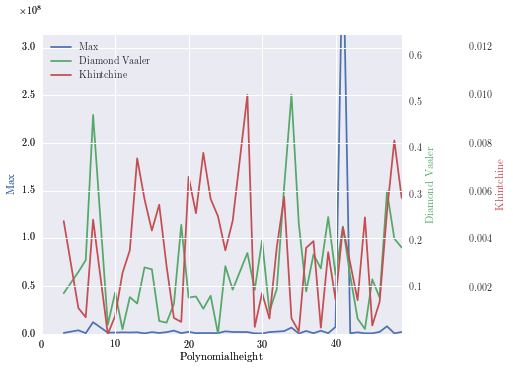

In [44]:
plot_table(heightdata,xaxis(heightdata, "height"),"height")

$x^{3} - 3$ & -243 & 460165 \\
$x^{4} - 4$ & -16384 & 782320 \\
$x^{5} - 5$ & 1953125 & 517394 \\
$x^{6} - 6$ & 362797056 & 791174 \\
$x^{7} - 7$ & -96889010407 & 608531 \\
$x^{8} - 8$ & -35184372088832 & 707770 \\
$x^{10} - 10$ & 10000000000000000000 & 734207 \\
$x^{11} - 11$ & -7400249944258160101211 & 418362 \\
$x^{12} - 12$ & -6624737266949237011120128 & 669334 \\
Poly & Discriminant & Max & DV & Khintchine  \\
$x^{3} - 3$ & -243 & 738358 & 0.0404537256889 & 0.00473441805285  \\
$x^{4} - 4$ & -16384 & 2 & 1.28818562788 & 0.685455314687  \\
$x^{5} - 5$ & 1953125 & 1993268 & 0.0548634388024 & 0.00238755097756  \\
$x^{6} - 6$ & 362797056 & 8291551 & 0.236344437875 & 0.00138919267668  \\
$x^{7} - 7$ & -96889010407 & 249800 & 0.101553564989 & 0.000421994016991  \\
$x^{8} - 8$ & -35184372088832 & 174507 & 0.15387807601 & 0.00167175684155  \\
$x^{10} - 10$ & 10000000000000000000 & 2632635 & 0.393949327838 & 0.000239595634951  \\
$x^{11} - 11$ & -7400249944258160101211 & 42708759 & 0.10909

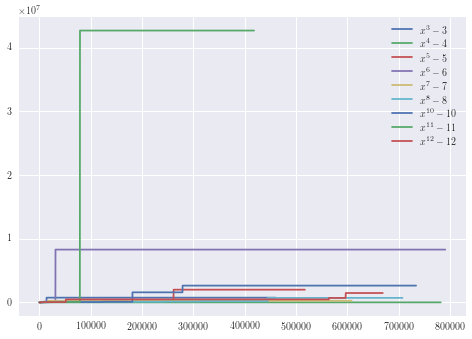

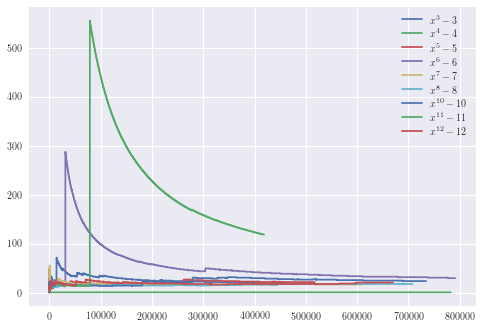

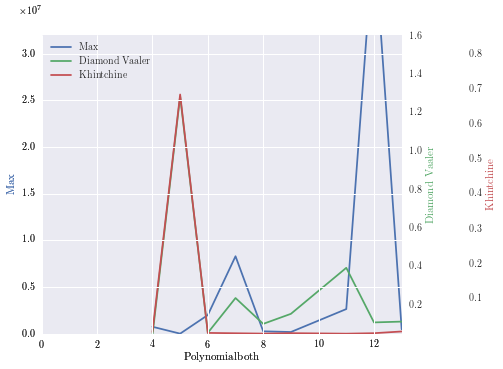

In [47]:
bothcf =doeverything("both", '/usr/userfs/s/sjb577/shared/cf/polysboth/','increasing_both.job.o1018762', disc_compare)

$x^{3} - 2$ & -108 & 787403 \\
$x^{4} - 2$ & -2048 & 852422 \\
$x^{5} - 2$ & 50000 & 772320 \\
$x^{6} - 2$ & 1492992 & 437375 \\
$x^{7} - 2$ & -52706752 & 543844 \\
$x^{8} - 2$ & -2147483648 & 521163 \\
$x^{9} - 2$ & 99179645184 & 486872 \\
$x^{10} - 2$ & 5120000000000 & 479348 \\
$x^{11} - 2$ & -292159150705664 & 433714 \\
$x^{12} - 2$ & -18260173718028288 & 391836 \\
Poly & Discriminant & Max & DV & Khintchine  \\
$x^{3} - 2$ & -108 & 533679 & 0.0433610994893 & 0.00257634502347  \\
$x^{4} - 2$ & -2048 & 956998 & 0.148099033819 & 5.66615678821e-05  \\
$x^{5} - 2$ & 50000 & 3391492 & 0.60374411127 & 0.00494036772046  \\
$x^{6} - 2$ & 1492992 & 1117075 & 0.00310226291411 & 0.00363693006404  \\
$x^{7} - 2$ & -52706752 & 197120 & 0.13570163027 & 0.00435056346925  \\
$x^{8} - 2$ & -2147483648 & 518113 & 0.0573554933425 & 0.00385428657691  \\
$x^{9} - 2$ & 99179645184 & 672533 & 0.179455680141 & 0.00466058976096  \\
$x^{10} - 2$ & 5120000000000 & 212506 & 0.171229452681 & 0.0034178331367  \

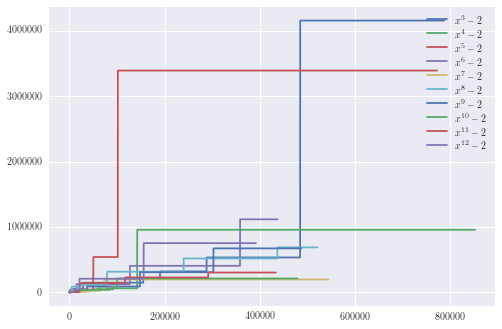

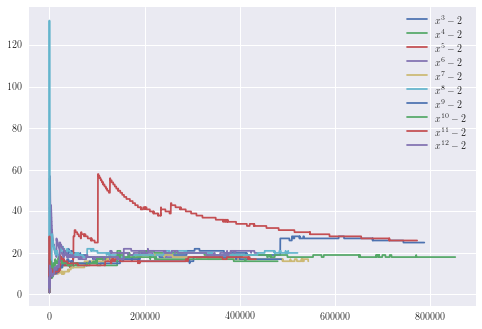

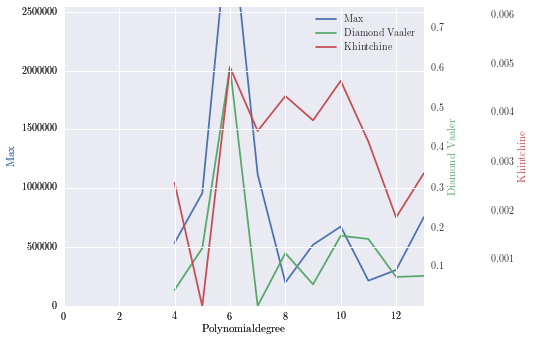

In [45]:
degreecf =doeverything("degree", '/usr/userfs/s/sjb577/shared/cf/polysdegree/','increasing_degree.job.o1018761', disc_compare)

In [57]:
degreecf[degreecf.keys()[2]][-10:]

[6, 2, 2, 2, 1, 1, 3, 1, 1, 3]

In [60]:
1/(log(2))-1.68545200107

-0.24275696018103665

In [ ]:

actual = [-math.log(1.0-1.0/pow(k+1.0,2),2) for k in range(1, 10)]
for i in actual:
    print(str(i)+ "\\\\")